# An Empirical Comparison of Supervised and Self-Supervised Learning

In [28]:
import tqdm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.svm import SVC
from sklearn.manifold import TSNE

from train import train_encoder, train_ConvNet, TrainArgs
from test import encode_data, plot_tsne, test_conv

from torch.utils.data import Subset

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baseline: convolutional neural network

In [30]:
conv_args = TrainArgs(batchsize = 10)

In [31]:
ConvNet, conv_losses = train_ConvNet(conv_args)

Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.301
[epoch: 2, i:   499] avg mini-batch loss: 2.293
[epoch: 3, i:   499] avg mini-batch loss: 2.246
[epoch: 4, i:   499] avg mini-batch loss: 2.164
[epoch: 5, i:   499] avg mini-batch loss: 2.120
[epoch: 6, i:   499] avg mini-batch loss: 2.065
[epoch: 7, i:   499] avg mini-batch loss: 2.000
[epoch: 8, i:   499] avg mini-batch loss: 1.931
[epoch: 9, i:   499] avg mini-batch loss: 1.775


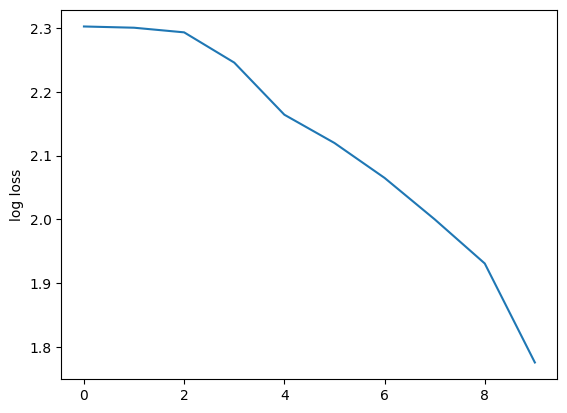

In [32]:
plt.plot(conv_losses);
plt.ylabel('log loss');

In [33]:
print(f'Baseline accuracy of the convolutional model is {test_conv(ConvNet)*100} %')

Files already downloaded and verified
Files already downloaded and verified
Baseline accuracy of the convolutional model is 38.211111111111116 %


## Momentum Contrast

### Pre-Training the Encoder

In [34]:
encoder_args = TrainArgs(epochs = 20)

In [35]:
encoder, enc_losses = train_encoder(encoder_args)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 	Loss: 0.048802
Train Epoch: 2 	Loss: 0.036550
Train Epoch: 3 	Loss: 0.030452
Train Epoch: 4 	Loss: 0.025949
Train Epoch: 5 	Loss: 0.021811
Train Epoch: 6 	Loss: 0.018988
Train Epoch: 7 	Loss: 0.016380
Train Epoch: 8 	Loss: 0.014324
Train Epoch: 9 	Loss: 0.012596
Train Epoch: 10 	Loss: 0.010954
Train Epoch: 11 	Loss: 0.009800
Train Epoch: 12 	Loss: 0.008741
Train Epoch: 13 	Loss: 0.007999
Train Epoch: 14 	Loss: 0.007047
Train Epoch: 15 	Loss: 0.006505
Train Epoch: 16 	Loss: 0.006139
Train Epoch: 17 	Loss: 0.005589
Train Epoch: 18 	Loss: 0.005049
Train Epoch: 19 	Loss: 0.004966
Train Epoch: 20 	Loss: 0.004591


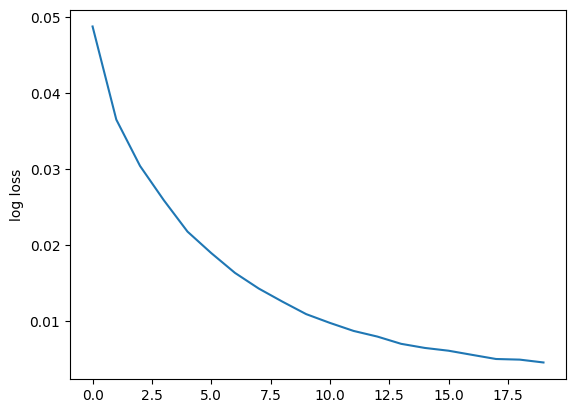

In [36]:
plt.plot(enc_losses);
plt.ylabel('log loss');

### Visualizing Embeddings

To do:
1. Implement multiple training ratios
2. Hyperparameter tuning?
3. Plot the loss functions

In [37]:
data, targets = encode_data()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 54000/54000 [11:20<00:00, 79.30it/s]   


In [38]:
ret = TSNE(n_components=2, random_state=0, n_jobs=8).fit_transform(data)

Files already downloaded and verified
Files already downloaded and verified


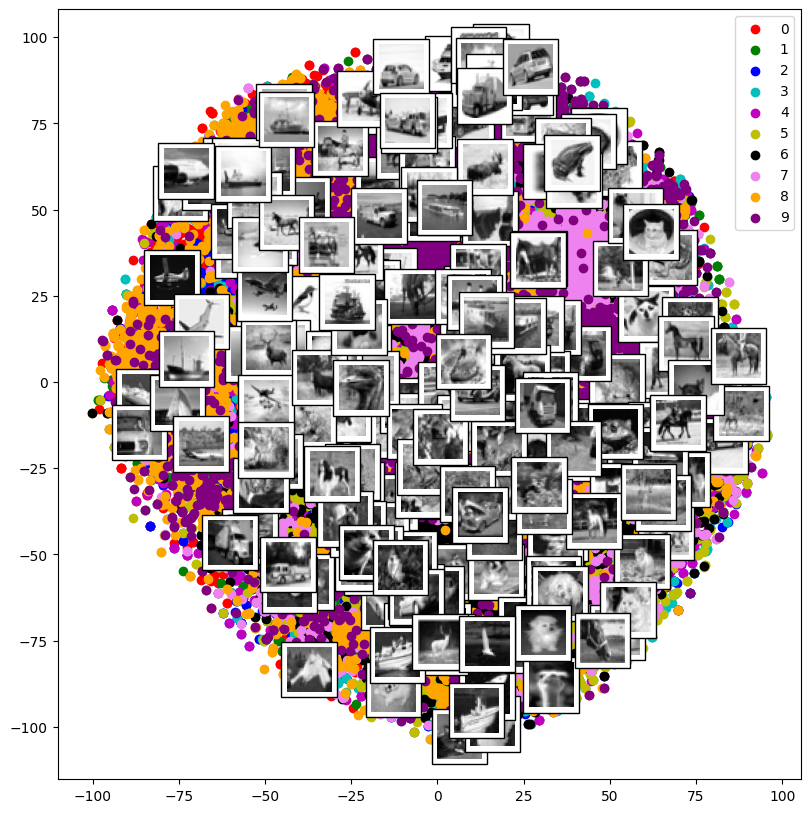

In [39]:
plot_tsne(targets, ret)

### Training SVM on freezed features

In [40]:
X_train, y_train = encode_data(train=True)
X_test, y_test = encode_data(train=False)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 6000/6000 [01:09<00:00, 85.92it/s]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 54000/54000 [10:33<00:00, 85.28it/s]


In [41]:
svm = SVC(C = 100,  gamma='scale')
svm.fit(X_train, y_train)

SVC(C=100)

In [42]:
svm.score(X_test, y_test)

0.5200370370370371

### Multiple Runs

In [43]:
# subsample so things run faster
X_train, y_train = encode_data(train=True)
X_test, y_test = encode_data(train=False)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 6000/6000 [01:11<00:00, 84.03it/s]


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 54000/54000 [10:35<00:00, 84.93it/s]


In [44]:
conv_args = TrainArgs(batchsize = 10, epochs = 5)

In [45]:
n = 3
conv_errors = []
svm_errors = []
for i in range(n):
    ConvNet, conv_losses = train_ConvNet(conv_args, subsample=False)
    conv_errors.append(test_conv(ConvNet, subsample=False)*100)
    
    svm = SVC(C = 100,  gamma='scale')
    svm.fit(X_train, y_train)   
    svm_errors.append(svm.score(X_test, y_test))

Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.296
[epoch: 2, i:   499] avg mini-batch loss: 2.281
[epoch: 3, i:   499] avg mini-batch loss: 2.210
[epoch: 4, i:   499] avg mini-batch loss: 2.070
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.302
[epoch: 1, i:   499] avg mini-batch loss: 2.296
[epoch: 2, i:   499] avg mini-batch loss: 2.273
[epoch: 3, i:   499] avg mini-batch loss: 2.186
[epoch: 4, i:   499] avg mini-batch loss: 2.103
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Started looping
[epoch: 0, i:   499] avg mini-batch loss: 2.301
[epoch: 1, i:   499] avg mini-batch loss: 2.

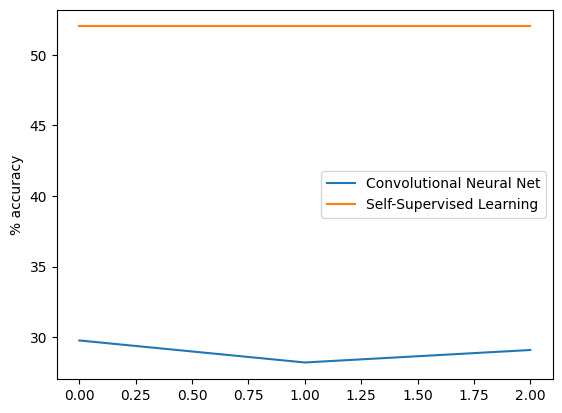

In [46]:
plt.plot(np.array(conv_errors), label="Convolutional Neural Net")
plt.plot(np.array(svm_errors)*100, label="Self-Supervised Learning")
plt.legend()
plt.ylabel('% accuracy')
plt.savefig('./results/comparison.png')

In [47]:
conv_errors

[29.772222222222222, 28.212962962962962, 29.0962962962963]

In [48]:
svm_errors

[0.5200370370370371, 0.5200370370370371, 0.5200370370370371]

In [49]:
conv_errors

[29.772222222222222, 28.212962962962962, 29.0962962962963]